# Running Wflow using the ewatercycle system

### 1. Copy an example case
To run WFlow, we need a complete parameterset. The easiest way to obtain a valid model configuration is by copying it from https://github.com/openstreams/wflow/raw/master/examples/. We can use `ewatercycle.parametersetdb` to easily copy on of these example cases to a folder called `./wflow_example_case`.

In [1]:
from ewatercycle.parametersetdb import build_from_urls

# Obtain an example case for testing the model
parameterset = build_from_urls(
    config_format='ini', config_url='https://github.com/openstreams/wflow/raw/master/examples/wflow_rhine_sbm/wflow_sbm.ini',
    datafiles_format='svn', datafiles_url='https://github.com/openstreams/wflow/trunk/examples/wflow_rhine_sbm',
)
parameterset.save_datafiles('./wflow_example_case')

### 2. Verify your configuration settings

If you are working on a curated environment like https://lab.ewatercycle.org/, the default configuration should cover 90% of all use cases. However, for the other 10% here is a brief explanation of the relevant configuration settings. 

The ewatercycle configuration file is typcially stored in `~/ewatercycle/ewatercycle.yaml` or `/etc/ewatercycle.yaml` and can be imported with `from ewatercycle import CFG`. Relevant settings for WFLow are:

```Yaml
container_engine: docker # or singularity
singularity_images.wflow: 'ewatercycle-wflow-grpc4bmi.sif'
docker_images.wflow: 'ewatercycle/wflow-grpc4bmi:latest'
```

In order for this to work, you need to make sure that the actual docker or singularity images are available on the system. This can be done with:

- Docker: `docker pull ewatercycle/wflow-grpc4bmi:latest`
- Singularity: `singularity build --disable-cache ewatercycle-wflow-grpc4bmi.sif docker://ewatercycle/wflow-grpc4bmi:latest`

### 3. Setting up the model

In [2]:
from ewatercycle.models import Wflow

In [3]:
model = Wflow()

There are 2 ways to set up the model: 

1. Pass the directory that contains the wflow parameterset directly as `work_dir`. Be careful, though, because the model may (over)write files inside the work_dir!
2. Pass the directory that contains the wflow parameterset as `parameterset`. In this case you can provide a different `work_dir`, e.g. a temporary directory. Wflow will copy the parameters to the temporary directory, so that the original parameters will remain untouched.

If you have create custom forcing, you can provide the path to the forcing data with the `forcing_data` parameter.

In [7]:
# Option 1:
config_file = model.setup(work_dir='./wflow_example_case', inifile='./wflow_example_case/wflow_sbm.ini')

# Option 2:
# config_file = model.setup(work_dir='./workdir', inifile='./wflow_example_case/wflow_sbm.ini', parameterset='./wflow_example_case')

config_file

Started Wflow container with working directory ./wflow_example_case


'wflow_sbm.ini'

The `config_file` that is returned by `setup(...)` can be used to initialize the model:

In [8]:
model.initialize(config_file)

### 4. Running the model

In [9]:
# Print a list of available parameters
model.parameters

('CanopyStorage',
 'FirstZoneDepth',
 'LowerZoneStorage',
 'Snow',
 'SnowWater',
 'SurfaceRunoff',
 'SurfaceRunoffDyn',
 'TSoil',
 'UStoreDepth',
 'WaterLevel',
 'WaterLevelDyn',
 'PotTransSoil',
 'Transpiration',
 'ActEvapOpenWater',
 'soilevap',
 'Interception',
 'ActEvap',
 'SurfaceRunoffCatchmentMM',
 'ExcessWater',
 'InfiltExcess',
 'ActInfilt',
 'zi',
 'Transfer',
 'CapFlux',
 'RunoffCoeff',
 'InwaterMM')

In [10]:
model.get_value("SurfaceRunoff")

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
model.get_value_as_xarray("SurfaceRunoff")

<xarray.DataArray 'SurfaceRunoff' (latitude: 169, longitude: 187)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * longitude  (longitude) float64 5.227 5.264 5.3 5.337 ... 11.97 12.01 12.05
  * latitude   (latitude) float64 45.89 45.93 45.97 46.0 ... 51.98 52.02 52.05
    time       object 1995-01-30 00:00:00
Attributes:
    units:     m^3/s

In [13]:
while model.time < model.end_time:
    model.update()

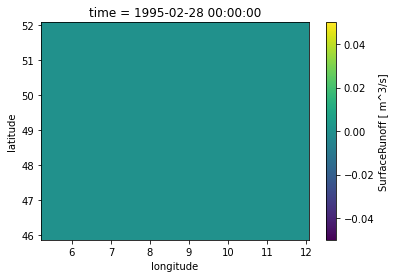

In [14]:
da = model.get_value_as_xarray("SurfaceRunoff")
da.plot()

In [15]:
model.finalize()